In [1]:
from datetime import date
from glob import glob
import json
import math
import os
from pathlib import Path
import pickle
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
%matplotlib widget

### Plot EEG electrodes

In [3]:
EEG_channel_coordinates = pd.DataFrame({
    'AP': [
            -4.14, -4.14, -4.14, -3.04, -3.04, -3.04, -1.96, -1.96, -1.96,
            -0.48, -0.48, 1.04, 1.04, 2.3, 2.3, 2.3, 2.3, 1.04, 1.04,
            -0.48, -0.48, -1.96, -1.96, -1.96, -3.04, -3.04, -3.04, -4.14,
            -4.14, -4.14
            ],
    'ML': [
            -4.05, -2.24, -1.0, -4.13, -2.88, -1.13, -4.05, -2.88, -1.12,
            -3.5, -2.12, -1.93, -0.5, -1.5, -0.5, 0.5, 1.5, 0.5, 1.93, 2.12,
            3.5, 1.12, 2.88, 4.05, 1.13, 2.88, 4.13, 1.0, 2.24, 4.05
            ]
})

Text(0.5, 1.0, 'EEG channel numbering')

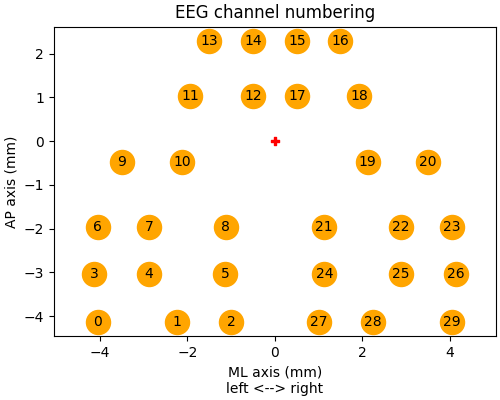

In [4]:
fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)

ax.scatter(EEG_channel_coordinates['ML'], EEG_channel_coordinates['AP'], s=300, color='orange')
ax.scatter(0, 0, marker='P', color='red')
ax.axis('equal')
    
for ind in range(len(EEG_channel_coordinates)):
    ax.annotate(str(ind),  xy=(EEG_channel_coordinates['ML'].iloc[ind], EEG_channel_coordinates['AP'].iloc[ind]), ha='center', va='center', color="k")

ax.set_xlabel('ML axis (mm)\nleft <--> right')
ax.set_ylabel('AP axis (mm)')
ax.set_title('EEG channel numbering')

### Choose a subject-session folder to access the EEG traces

Input the subject/session folder here

In [5]:
subfolder = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\Templeton\mouse_EEG_VEPs\white_circles\psilocybin\mouse676727_2023-05-10")
print(os.listdir(subfolder))

['events_postinj.npy', 'events_preinj.npy', 'event_timestamps.npy']


In [6]:
event_timestamps = np.load(os.path.join(subfolder, 'event_timestamps.npy'))
events_preinj = np.load(os.path.join(subfolder, 'events_preinj.npy'))
events_postinj = np.load(os.path.join(subfolder, 'events_postinj.npy'))
print(event_timestamps.shape)
print(events_preinj.shape)

(10000,)
(10000, 30, 120)


In [7]:
EEG_sample_rate = 2500

Plot the raw traces

Text(0.5, 1.0, 'Raw traces and trial average for ch 4')

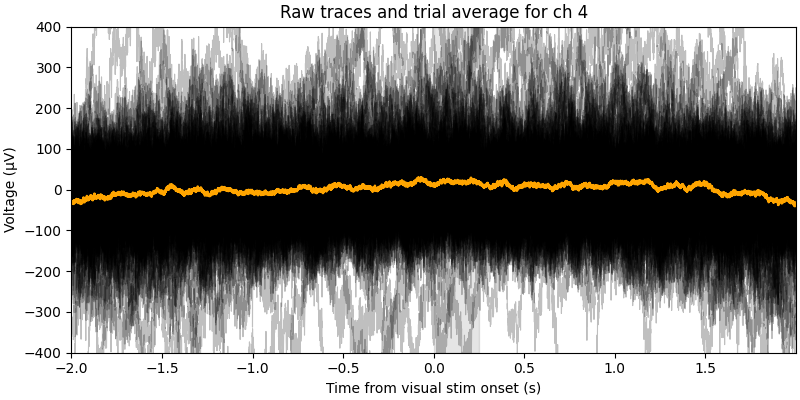

In [8]:
plot_ch = 4
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
ax.axvspan(0, 0.25, color='k', alpha=0.1)
ax.plot(event_timestamps, events_preinj[:, plot_ch, :], color='k', linewidth=0.8, alpha=0.25)
ax.plot(event_timestamps, np.mean(events_preinj[:, plot_ch, :], 1), color='orange', linewidth=1.75)
ax.set_xlim([event_timestamps[0], event_timestamps[-1]])
ax.set_ylim([-400, 400])
ax.set_xlabel('Time from visual stim onset (s)')
ax.set_ylabel('Voltage (\u03bcV)')
ax.set_title('Raw traces and trial average for ch {:d}'.format(plot_ch))

Apply common average reference

In [9]:
preinj_CA = events_preinj - np.nanmean(events_preinj, axis=1)[:,None,:]

Text(0.5, 1.0, 'Com-avg filtered traces and trial average for ch 4')

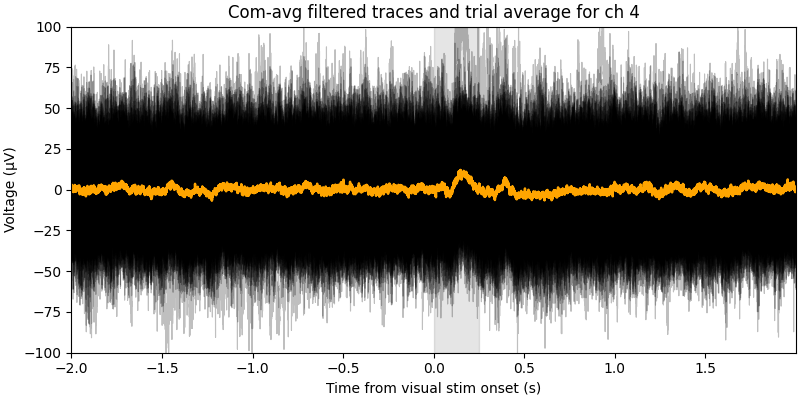

In [10]:
plot_ch = 4
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
ax.axvspan(0, 0.25, color='k', alpha=0.1)
ax.plot(event_timestamps, preinj_CA[:, plot_ch, :], color='k', linewidth=0.8, alpha=0.25)
ax.plot(event_timestamps, np.mean(preinj_CA[:, plot_ch, :], 1), color='orange', linewidth=1.75)
ax.set_xlim([event_timestamps[0], event_timestamps[-1]])
ax.set_ylim([-100, 100])
ax.set_xlabel('Time from visual stim onset (s)')
ax.set_ylabel('Voltage (\u03bcV)')
ax.set_title('Com-avg filtered traces and trial average for ch {:d}'.format(plot_ch))

Apply bandpass filter

In [11]:
bpb, bpa = signal.butter(3, np.array([0.5, 20])/(EEG_sample_rate/2), btype='bandpass')
preinj_CAfilt = signal.filtfilt(bpb, bpa, preinj_CA, axis=0)

Text(0.5, 1.0, 'Filtered traces and trial average for ch 4')

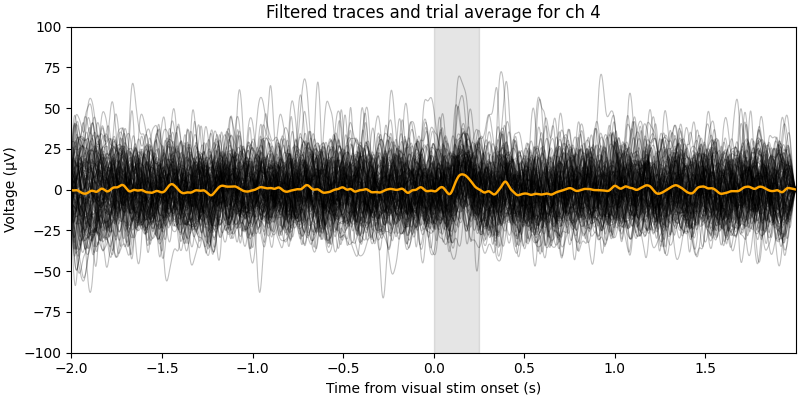

In [12]:
plot_ch = 4
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
ax.axvspan(0, 0.25, color='k', alpha=0.1)
ax.plot(event_timestamps, preinj_CAfilt[:, plot_ch, :], color='k', linewidth=0.8, alpha=0.25)
ax.plot(event_timestamps, np.mean(preinj_CAfilt[:, plot_ch, :], 1), color='orange', linewidth=1.75)
ax.set_xlim([event_timestamps[0], event_timestamps[-1]])
ax.set_ylim([-100, 100])
ax.set_xlabel('Time from visual stim onset (s)')
ax.set_ylabel('Voltage (\u03bcV)')
ax.set_title('Filtered traces and trial average for ch {:d}'.format(plot_ch))

Plot all chs, trial avg

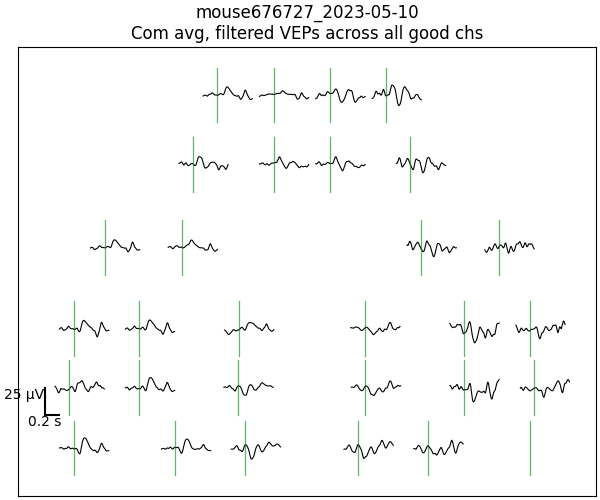

In [13]:
prex = .2 # s before stim to plot
postx = .5 # s after stim to plot
xmult = 0.8 # changes horizontal distance between traces, usually 0.8
ymult = 50 # changes vertical distance between traces, usually 100 for VEPs

timex = event_timestamps
plottraces = np.mean(preinj_CAfilt, 2)
pinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
for chi in range(len(EEG_channel_coordinates)):
    trace_color = 'k'
    ax.plot(
        timex[pinds] + (EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        plottraces[pinds, chi] + (EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        trace_color,
        linewidth=0.8
    )
    # this adds a vertical green line at stim onset time #
    ax.plot([0.+(EEG_channel_coordinates['ML'].iloc[chi]*xmult),
             0.+(EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
            [-25+(EEG_channel_coordinates['AP'].iloc[chi]*ymult),
             25+(EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
            color='g', linewidth=0.9, alpha=0.6)
    if chi == 3:
        mx = timex[0] + EEG_channel_coordinates['ML'].iloc[chi] * xmult * 0.5
        my = EEG_channel_coordinates['AP'].iloc[chi] * ymult

## This plots a scale bar in the bottom left corner ##
x_len = .2 # x scale bar length in ms
y_len = 25 # y scale bar length in uV, for VEP: 25
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

## Set title ##
ax.set_title('{}\nCom avg, filtered VEPs across all good chs'.format(os.path.basename(subfolder)))
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

Plot pre and post together

In [14]:
postinj_CA = events_postinj - np.nanmean(events_postinj, axis=1)[:,None,:]
postinj_CAfilt = signal.filtfilt(bpb, bpa, postinj_CA, axis=0)

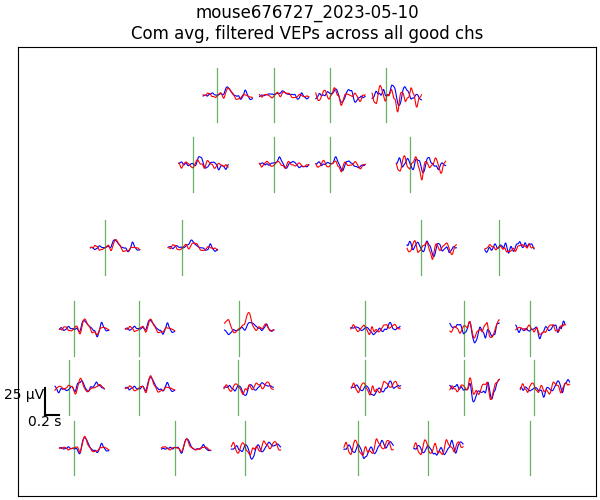

In [15]:
prex = .2 # s before stim to plot
postx = .5 # s after stim to plot
xmult = 0.8 # changes horizontal distance between traces, usually 0.8
ymult = 50 # changes vertical distance between traces, usually 100 for VEPs

timex = event_timestamps
pretraces = np.mean(preinj_CAfilt, 2)
posttraces = np.mean(postinj_CAfilt, 2)
pinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
for chi in range(len(EEG_channel_coordinates)):
    ax.plot(
        timex[pinds] + (EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        pretraces[pinds, chi] + (EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        'b', linewidth=0.8
    )
    ax.plot(
        timex[pinds] + (EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        posttraces[pinds, chi] + (EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        'r', linewidth=0.8
    )
    # this adds a vertical green line at stim onset time #
    ax.plot([0.+(EEG_channel_coordinates['ML'].iloc[chi]*xmult),
             0.+(EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
            [-25+(EEG_channel_coordinates['AP'].iloc[chi]*ymult),
             25+(EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
            color='g', linewidth=0.9, alpha=0.6)
    if chi == 3:
        mx = timex[0] + EEG_channel_coordinates['ML'].iloc[chi] * xmult * 0.5
        my = EEG_channel_coordinates['AP'].iloc[chi] * ymult

## This plots a scale bar in the bottom left corner ##
x_len = .2 # x scale bar length in ms
y_len = 25 # y scale bar length in uV, for VEP: 25
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

## Set title ##
ax.set_title('{}\nCom avg, filtered VEPs across all good chs'.format(os.path.basename(subfolder)))
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

## Loop through all subjects

In [17]:
EEG_sample_rate = 2500

In [18]:
statefolder = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\Templeton\mouse_EEG_VEPs\white_circles\psilocybin")
print(os.listdir(statefolder))

['mouse676726_2023-05-03', 'mouse676727_2023-05-10', 'mouse689242_2023-07-19', 'mouse703063_2023-11-15', 'mouse703064_2023-11-30', 'mouse703065_2023-12-06', 'mouse709401_2023-12-14']


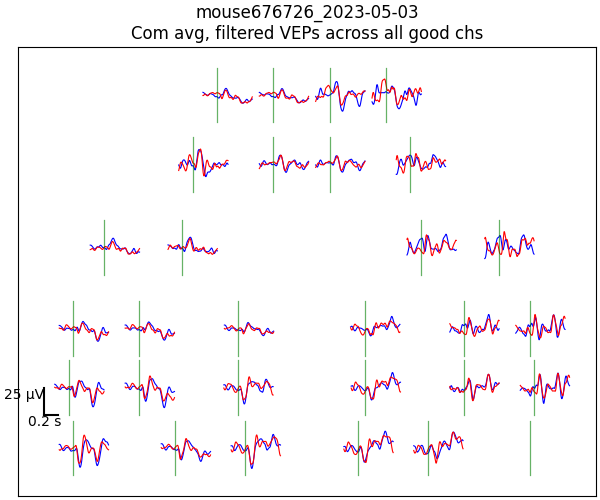

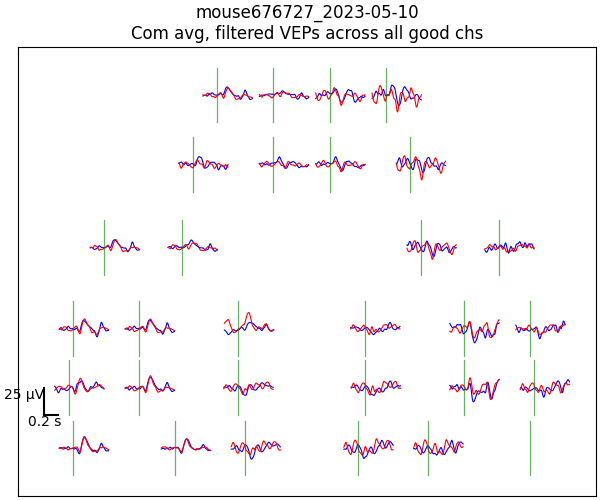

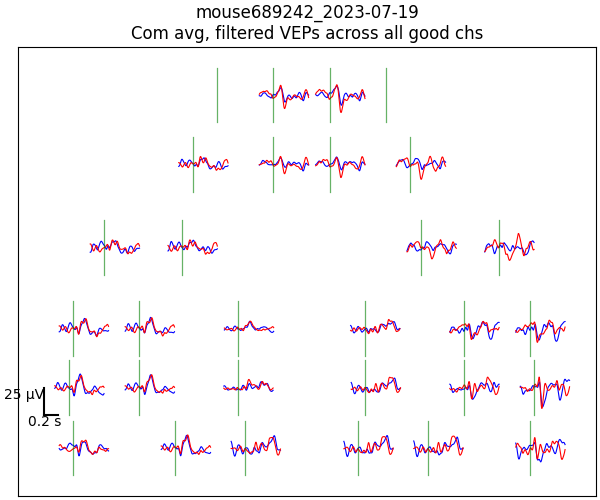

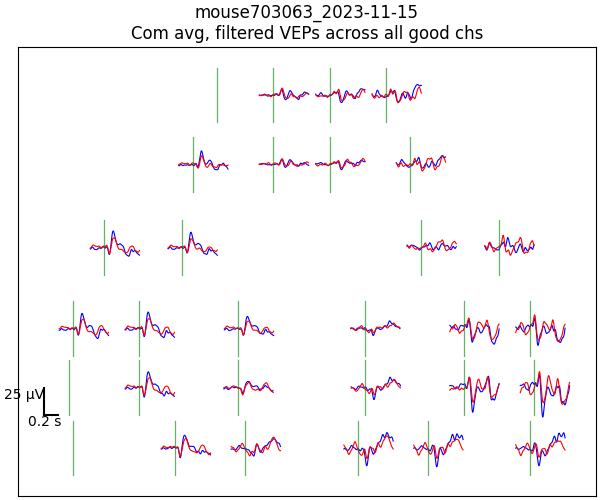

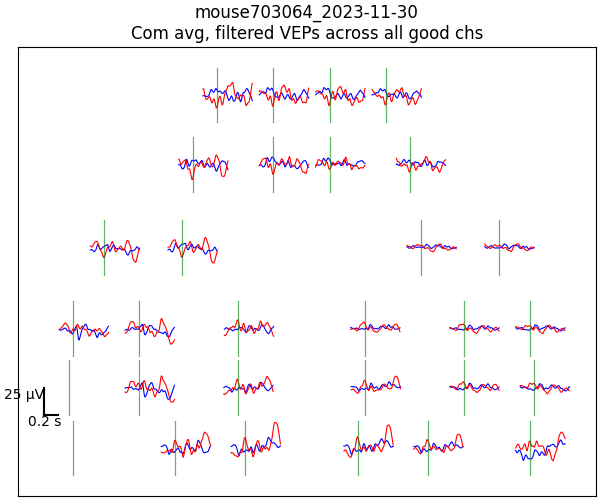

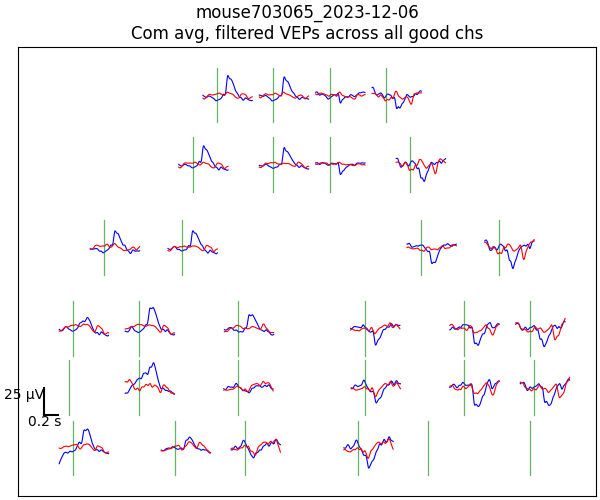

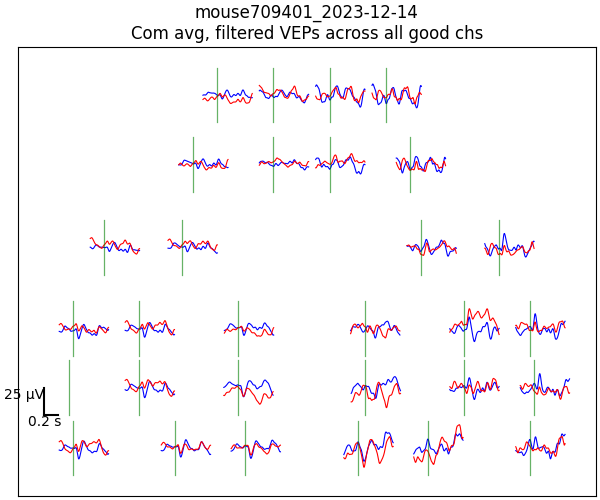

In [20]:
for subfolder in os.listdir(statefolder):
    event_timestamps = np.load(os.path.join(statefolder, subfolder, 'event_timestamps.npy'))
    events_preinj = np.load(os.path.join(statefolder, subfolder, 'events_preinj.npy'))
    events_postinj = np.load(os.path.join(statefolder, subfolder, 'events_postinj.npy'))

    ## Common average ##
    events_preinj = events_preinj - np.nanmean(events_preinj, axis=1)[:,None,:]
    events_postinj = events_postinj - np.nanmean(events_postinj, axis=1)[:,None,:]

    ## Bandpass filter ##
    bpb, bpa = signal.butter(3, np.array([0.5, 20])/(EEG_sample_rate/2), btype='bandpass')
    events_preinj = signal.filtfilt(bpb, bpa, events_preinj, axis=0)
    events_postinj = signal.filtfilt(bpb, bpa, events_postinj, axis=0)

    ### Make the plot ###
    prex = .2 # s before stim to plot
    postx = .5 # s after stim to plot
    xmult = 0.8 # changes horizontal distance between traces, usually 0.8
    ymult = 50 # changes vertical distance between traces, usually 100 for VEPs
    
    timex = event_timestamps
    pretraces = np.mean(events_preinj, 2)
    posttraces = np.mean(events_postinj, 2)
    pinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))
    
    fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
    for chi in range(len(EEG_channel_coordinates)):
        ax.plot(
            timex[pinds] + (EEG_channel_coordinates['ML'].iloc[chi] * xmult),
            pretraces[pinds, chi] + (EEG_channel_coordinates['AP'].iloc[chi] * ymult),
            'b', linewidth=0.8
        )
        ax.plot(
            timex[pinds] + (EEG_channel_coordinates['ML'].iloc[chi] * xmult),
            posttraces[pinds, chi] + (EEG_channel_coordinates['AP'].iloc[chi] * ymult),
            'r', linewidth=0.8
        )
        # this adds a vertical green line at stim onset time #
        ax.plot([0.+(EEG_channel_coordinates['ML'].iloc[chi]*xmult),
                 0.+(EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
                [-25+(EEG_channel_coordinates['AP'].iloc[chi]*ymult),
                 25+(EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
                color='g', linewidth=0.9, alpha=0.6)
        if chi == 3:
            mx = timex[0] + EEG_channel_coordinates['ML'].iloc[chi] * xmult * 0.5
            my = EEG_channel_coordinates['AP'].iloc[chi] * ymult
    
    ## This plots a scale bar in the bottom left corner ##
    x_len = .2 # x scale bar length in ms
    y_len = 25 # y scale bar length in uV, for VEP: 25
    ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
    ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
    ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
    ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')
    
    ## Set title ##
    ax.set_title('{}\nCom avg, filtered VEPs across all good chs'.format(subfolder))
    plt.tick_params(axis='x', bottom=False, labelbottom=False)
    plt.tick_params(axis='y', left=False, labelleft=False)

    ## Save ##
    figname = '{}_prepostVEP.png'.format(subfolder)
    fig.savefig(os.path.join(statefolder, subfolder, figname), transparent=False, dpi=150)